In [1]:
!pip install mlflow

In [2]:
import mlflow
import mlflow.sklearn
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

In [3]:
# Define the stocks
primary_stock = 'NVDA'
competitor_stock = 'QUBT'
market_index = '^GSPC'
stocks = [primary_stock, competitor_stock, market_index]

In [4]:
# Fetch historical data
start_date = '2010-01-02'
end_date = '2024-02-12'

In [5]:
df = yf.download(stocks, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [6]:
df.head()

Price          Close                          High                      \
Ticker          NVDA   QUBT        ^GSPC      NVDA   QUBT        ^GSPC   
Date                                                                     
2010-01-04  0.423884  190.0  1132.989990  0.426864  190.0  1133.869995   
2010-01-05  0.430073  220.0  1136.520020  0.434658  220.0  1136.630005   
2010-01-06  0.432824  194.0  1137.140015  0.433741  220.0  1139.189941   
2010-01-07  0.424342  200.0  1141.689941  0.432366  200.0  1142.459961   
2010-01-08  0.425259  190.0  1144.979980  0.428239  200.0  1145.390015   

Price            Low                          Open                      \
Ticker          NVDA   QUBT        ^GSPC      NVDA   QUBT        ^GSPC   
Date                                                                     
2010-01-04  0.415172  180.0  1116.560059  0.424342  190.0  1116.560059   
2010-01-05  0.422279  190.0  1129.660034  0.422279  190.0  1132.660034   
2010-01-06  0.425718  190.0  1133.949951  0.429844  220.0  1135.709961   
2010-01-07  0.421133  190.0  1131.319946  0.430532  194.0  1136.270020   
2010-01-08  0.418382  190.0  1136.219971  0.420903  200.0  1140.520020   

Price          Volume                   
Ticker           NVDA QUBT       ^GSPC  
Date                                    
2010-01-04  800204000   29  3991400000  
2010-01-05  728648000  212  2491020000  
2010-01-06  649168000   99  4972660000  
2010-01-07  547792000  137  5270680000  
2010-01-08  478168000   70  4389590000

In [7]:
df.tail()

Price           Close                           High                      \
Ticker           NVDA   QUBT        ^GSPC       NVDA   QUBT        ^GSPC   
Date                                                                       
2024-02-05  69.305977  0.762  4942.810059  69.470916  0.807  4957.189941   
2024-02-06  68.197395  0.731  4954.229980  69.727819  0.769  4957.770020   
2024-02-07  70.072678  0.736  4995.060059  70.193634  0.756  4999.890137   
2024-02-08  69.614853  0.735  4997.910156  70.767420  0.750  5000.399902   
2024-02-09  72.105934  0.749  5026.609863  72.157909  0.750  5030.060059   

Price             Low                           Open                      \
Ticker           NVDA   QUBT        ^GSPC       NVDA   QUBT        ^GSPC   
Date                                                                       
2024-02-05  67.179776  0.750  4918.089844  68.199390  0.800  4957.189941   
2024-02-06  66.275121  0.716  4934.879883  69.603865  0.760  4950.160156   
2024-02-07  67.574615  0.712  4969.049805  68.293347  0.731  4973.049805   
2024-02-08  69.428926  0.720  4987.089844  70.047689  0.740  4995.160156   
2024-02-09  70.185650  0.712  5000.339844  70.506528  0.722  5004.169922   

Price          Volume                       
Ticker           NVDA     QUBT       ^GSPC  
Date                                        
2024-02-05  680078000   816400  4023640000  
2024-02-06  683111000  1102100  4440880000  
2024-02-07  495575000   477200  4895590000  
2024-02-08  414422000   537200  4341860000  
2024-02-09  436637000   674600  3912990000

In [8]:
# 1. Flatten the MultiIndex columns
df.columns = [f"{col2}_{col1}" for col1, col2 in df.columns]

# 2. Rename S&P 500 symbol to something readable
df = df.rename(columns=lambda x: x.replace("^GSPC", "GSPC"))

# 3. Check the result
print(df.head())

            NVDA_Close  QUBT_Close   GSPC_Close  NVDA_High  QUBT_High  \
Date                                                                    
2010-01-04    0.423884       190.0  1132.989990   0.426864      190.0   
2010-01-05    0.430073       220.0  1136.520020   0.434658      220.0   
2010-01-06    0.432824       194.0  1137.140015   0.433741      220.0   
2010-01-07    0.424342       200.0  1141.689941   0.432366      200.0   
2010-01-08    0.425259       190.0  1144.979980   0.428239      200.0   

              GSPC_High  NVDA_Low  QUBT_Low     GSPC_Low  NVDA_Open  \
Date                                                                  
2010-01-04  1133.869995  0.415172     180.0  1116.560059   0.424342   
2010-01-05  1136.630005  0.422279     190.0  1129.660034   0.422279   
2010-01-06  1139.189941  0.425718     190.0  1133.949951   0.429844   
2010-01-07  1142.459961  0.421133     190.0  1131.319946   0.430532   
2010-01-08  1145.390015  0.418382     190.0  1136.219971   0.4

In [9]:
df.shape

(3550, 15)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3550 entries, 2010-01-04 to 2024-02-09
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NVDA_Close   3550 non-null   float64
 1   QUBT_Close   3550 non-null   float64
 2   GSPC_Close   3550 non-null   float64
 3   NVDA_High    3550 non-null   float64
 4   QUBT_High    3550 non-null   float64
 5   GSPC_High    3550 non-null   float64
 6   NVDA_Low     3550 non-null   float64
 7   QUBT_Low     3550 non-null   float64
 8   GSPC_Low     3550 non-null   float64
 9   NVDA_Open    3550 non-null   float64
 10  QUBT_Open    3550 non-null   float64
 11  GSPC_Open    3550 non-null   float64
 12  NVDA_Volume  3550 non-null   int64  
 13  QUBT_Volume  3550 non-null   int64  
 14  GSPC_Volume  3550 non-null   int64  
dtypes: float64(12), int64(3)
memory usage: 443.8 KB


In [11]:
df.isnull().sum()

NVDA_Close     0
QUBT_Close     0
GSPC_Close     0
NVDA_High      0
QUBT_High      0
GSPC_High      0
NVDA_Low       0
QUBT_Low       0
GSPC_Low       0
NVDA_Open      0
QUBT_Open      0
GSPC_Open      0
NVDA_Volume    0
QUBT_Volume    0
GSPC_Volume    0
dtype: int64

In [12]:
df.describe()

,NVDA_Close,QUBT_Close,GSPC_Close,NVDA_High,QUBT_High,GSPC_High,NVDA_Low,QUBT_Low,GSPC_Low,NVDA_Open,QUBT_Open,GSPC_Open,NVDA_Volume,QUBT_Volume,GSPC_Volume
count,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3.550000e+03,3.550000e+03,3.550000e+03
mean,7.674762,7.000544,2553.315462,7.805099,7.493617,2566.621212,7.527095,6.434399,2537.891067,7.667463,7.023813,2552.708432,5.053042e+08,1.329900e+05,3.941416e+09
std,11.795556,23.551790,1085.735883,11.982188,24.995346,1091.801727,11.570861,21.669762,1079.042834,11.778029,23.725324,1085.482053,3.114963e+08,9.319602e+05,9.589124e+08
min,0.203574,0.015000,1022.580017,0.207471,0.015000,1032.949951,0.198301,0.015000,1010.909973,0.199906,0.015000,1027.650024,4.564400e+07,0.000000e+00,1.025000e+09
25%,0.393049,0.600000,1654.577515,0.399583,0.600000,1659.790039,0.385943,0.600000,1646.522491,0.392534,0.600000,1652.562531,3.087650e+08,0.000000e+00,3.365188e+09
50%,2.502517,2.600000,2274.979980,2.535195,2.750000,2279.180054,2.456274,2.490000,2266.414917,2.505969,2.600000,2272.319946,4.344320e+08,5.600000e+01,3.782310e+09
75%,10.580423,5.310000,3327.167480,10.751123,5.730000,3340.230042,10.385926,5.000000,3315.895081,10.559368,5.300000,3324.597412,6.126030e+08,3.190000e+04,4.315380e+09
max,72.105934,238.000000,5026.609863,72.157909,240.000000,5030.060059,70.185650,220.000000,5000.339844,70.506528,240.000000,5004.169922,3.692928e+09,3.033620e+07,1.061781e+10


### Insight

NVDA
* It has had massive growth over the observed period. Prices ranged from under $1 to over $70 (possibly reflecting stock splits or price adjustments). The high standard deviation indicates high volatility, especially recently.
  
* Volume ranged widely too — indicating days of heavy trading and news impacts.

QUBT

QUBT’s prices have been extremely volatile, swinging from near-zero to over $200 — likely driven by speculative spikes and low liquidity.

The zero volume minimum and low 25th percentile suggest many days of little or no trading.

S&P500
* The S&P 500 has more stable and gradual growth, with prices moving from ~1,000 to over 5,000.

* Lower volatility compared to the stocks, reflecting the index’s diversified nature.

* Volume is consistently high, as expected for a major market index.

### Observations

1. NVDA has grown steadily and significantly over the period with increasing volume and volatility.

2. QUBT shows extreme volatility, likely due to its small-cap status and speculative trading.

3. S&P 500 (^GSPC) acts as a market benchmark with relatively stable growth.

4. Stock Volumes suggest NVDA and GSPC are heavily traded, while QUBT experiences many low- or no-trade days.

### Feature Engineering

* Computing the stocks the Return feature
* Creating a "tomorrow" column (next day's close price)
* Creating a "stocks-Direction" column (tomorrow's price > adj Close Price) : The direction column provides binary observations of daily price movements, indicating whether the stock price moved up or down (Target feature)

### Stocks Return

In [20]:
# Compute daily percentage change (returns) for all stocks
returns_df = df.pct_change()

# Rename columns to indicate returns
returns_df = returns_df.add_suffix("_Return")

# Merge returns with original dataset
df = df.join(returns_df)

# Drop NaN values caused by first-day percentage change
df.dropna(inplace=True)

# Save dataset with computed returns
df.to_csv("stock_returns_data.csv")

# Show first rows
print("Stock returns computed successfully and saved as 'stock_returns_data.csv'")
print(df.head())

Stock returns computed successfully and saved as 'stock_returns_data.csv'
            NVDA_Close  QUBT_Close   GSPC_Close  NVDA_High  QUBT_High  \
Date                                                                    
2010-01-05    0.430073       220.0  1136.520020   0.434658      220.0   
2010-01-06    0.432824       194.0  1137.140015   0.433741      220.0   
2010-01-07    0.424342       200.0  1141.689941   0.432366      200.0   
2010-01-08    0.425259       190.0  1144.979980   0.428239      200.0   
2010-01-11    0.419299       194.0  1146.979980   0.429386      200.0   

              GSPC_High  NVDA_Low  QUBT_Low     GSPC_Low  NVDA_Open  ...  \
Date                                                                 ...   
2010-01-05  1136.630005  0.422279     190.0  1129.660034   0.422279  ...   
2010-01-06  1139.189941  0.425718     190.0  1133.949951   0.429844  ...   
2010-01-07  1142.459961  0.421133     190.0  1131.319946   0.430532  ...   
2010-01-08  1145.390015  0.418382 

* NVDA closed at $0.43
  
* QUBT closed at $220

* S&P 500 closed at 1136.52

* NVDA's low increased by 1.7% from the previous day

* QUBT's volume surged over 6x (likely low base value previously)

* GSPC_Volume_Return	-0.375903 meaning S&P 500's volume dropped ~37.6% from the prior day

In [22]:
df = pd.read_csv("stock_returns_data.csv", parse_dates=["Date"], index_col="Date")

# Print available columns
print("Columns in the dataset:", df.columns)

# Adjust column names if needed
for stock in ["NVDA_Close", "QUBT_Close"]:  # Ensure correct column names
    df[f"{stock}_Tomorrow"] = df[stock].shift(-1)

# Drop last row with NaN values
df.dropna(inplace=True)

# Save updated dataset
df.to_csv("stock_with_tomorrow.csv")

print("Tomorrow column created successfully and saved as 'stock_with_tomorrow.csv'")
print(df.head())

Columns in the dataset: Index(['NVDA_Close', 'QUBT_Close', 'GSPC_Close', 'NVDA_High', 'QUBT_High',
       'GSPC_High', 'NVDA_Low', 'QUBT_Low', 'GSPC_Low', 'NVDA_Open',
       'QUBT_Open', 'GSPC_Open', 'NVDA_Volume', 'QUBT_Volume', 'GSPC_Volume',
       'NVDA_Close_Return', 'QUBT_Close_Return', 'GSPC_Close_Return',
       'NVDA_High_Return', 'QUBT_High_Return', 'GSPC_High_Return',
       'NVDA_Low_Return', 'QUBT_Low_Return', 'GSPC_Low_Return',
       'NVDA_Open_Return', 'QUBT_Open_Return', 'GSPC_Open_Return',
       'NVDA_Volume_Return', 'QUBT_Volume_Return', 'GSPC_Volume_Return'],
      dtype='object')
Tomorrow column created successfully and saved as 'stock_with_tomorrow.csv'
            NVDA_Close  QUBT_Close   GSPC_Close  NVDA_High  QUBT_High  \
Date                                                                    
2010-01-05    0.430073       220.0  1136.520020   0.434658      220.0   
2010-01-06    0.432824       194.0  1137.140015   0.433741      220.0   
2010-01-07    0.424342

### Insight

1.Column: "NVDA_Close_Tomorrow"

* The closing price of NVDA on the next day.

* Example: On Jan 5, 2010, NVDA_Close was 0.43, and NVDA_Close_Tomorrow (Jan 6, 2010) was 0.432.Slight price increase roughly 0.63%

2.Column: "QUBT_Close_Tomorrow"

* The closing price of QUBT on the next day.

* Example: On Jan 5, 2010, QUBT_Close was 220, and QUBT_Close_Tomorrow (Jan 6, 2010) was 194.A decrease in stock price

In [25]:
df = pd.read_csv("stock_with_tomorrow.csv", parse_dates=["Date"], index_col="Date")

# Verify column names
print(df.columns)

# Create Stock_Direction column
for stock in ["NVDA", "QUBT"]:
    df[f"{stock}_Direction"] = (df[f"{stock}_Close_Tomorrow"] > df[f"{stock}_Close"]).astype(int)

# Drop last row (since "Tomorrow" values don't exist for the last date)
df.dropna(inplace=True)

# Save updated dataset
df.to_csv("stock_with_direction.csv")

print("Stock_Direction column created successfully and saved as 'stock_with_direction.csv'")
print(df.tail())

Index(['NVDA_Close', 'QUBT_Close', 'GSPC_Close', 'NVDA_High', 'QUBT_High',
       'GSPC_High', 'NVDA_Low', 'QUBT_Low', 'GSPC_Low', 'NVDA_Open',
       'QUBT_Open', 'GSPC_Open', 'NVDA_Volume', 'QUBT_Volume', 'GSPC_Volume',
       'NVDA_Close_Return', 'QUBT_Close_Return', 'GSPC_Close_Return',
       'NVDA_High_Return', 'QUBT_High_Return', 'GSPC_High_Return',
       'NVDA_Low_Return', 'QUBT_Low_Return', 'GSPC_Low_Return',
       'NVDA_Open_Return', 'QUBT_Open_Return', 'GSPC_Open_Return',
       'NVDA_Volume_Return', 'QUBT_Volume_Return', 'GSPC_Volume_Return',
       'NVDA_Close_Tomorrow', 'QUBT_Close_Tomorrow'],
      dtype='object')
Stock_Direction column created successfully and saved as 'stock_with_direction.csv'
            NVDA_Close  QUBT_Close   GSPC_Close  NVDA_High  QUBT_High  \
Date                                                                    
2024-02-02   66.135170       0.790  4958.609863  66.575000      0.800   
2024-02-05   69.305977       0.762  4942.810059  69.470916

Observations from date range: February 2 - 8 2024 (5trading days)

Date	     NVDA_Close	  NVDA_Tomorrow	   Direction	    QUBT_Close	                QUBT_Tomorrow	                                  Direction
2024-02-02 	  66.14	       69.31	          📈 1	             0.790	                 0.762	🔻                                       0
2024-02-05	  69.31	       68.20	          🔻 0	             0.762	                 0.731	🔻                                       0
2024-02-06	  68.20	       70.07	          📈 1	             0.731	                 0.736	📈                                       1
2024-02-07	  70.07	       69.61	          🔻 0	             0.736	                 0.735	🔻                                       0
2024-02-08	  69.61	       72.11	          📈 1	             0.735	                 0.749	📈                                       1

Insights

1. Direction Fluctuation (Volatility)
NVDA: Alternates between increases and decreases. Out of 5 days:

3 days the price went up (Feb 2, 6, 8)

2 days it went down (Feb 5, 7)

QUBT: More volatile, but less consistent in direction:

2 ups (Feb 6, 8)

3 downs (Feb 2, 5, 7)

 2. NVDA Momentum
Feb 2 to Feb 5: Strong upward move from 66.14 to 69.31 (~4.8%)

Followed by a slight dip, then a rebound on Feb 6 and Feb 8

Suggests bullish sentiment but with intermittent pullbacks

 3. QUBT Smaller Movements
Prices fluctuate in a tighter range (between 0.731 and 0.790)

Changes are more frequent but smaller — likely due to lower liquidity or market cap

 4. Volume Impact
NVDA had high volume return on Feb 5 (0.427) and Feb 2 (0.291) — coinciding with significant upward moves.

QUBT had a notable negative volume return on Feb 7 (-0.567) — coinciding with price decline.


### Exploratory Data Analysis

### Stock price Trends, Returns and Volatility

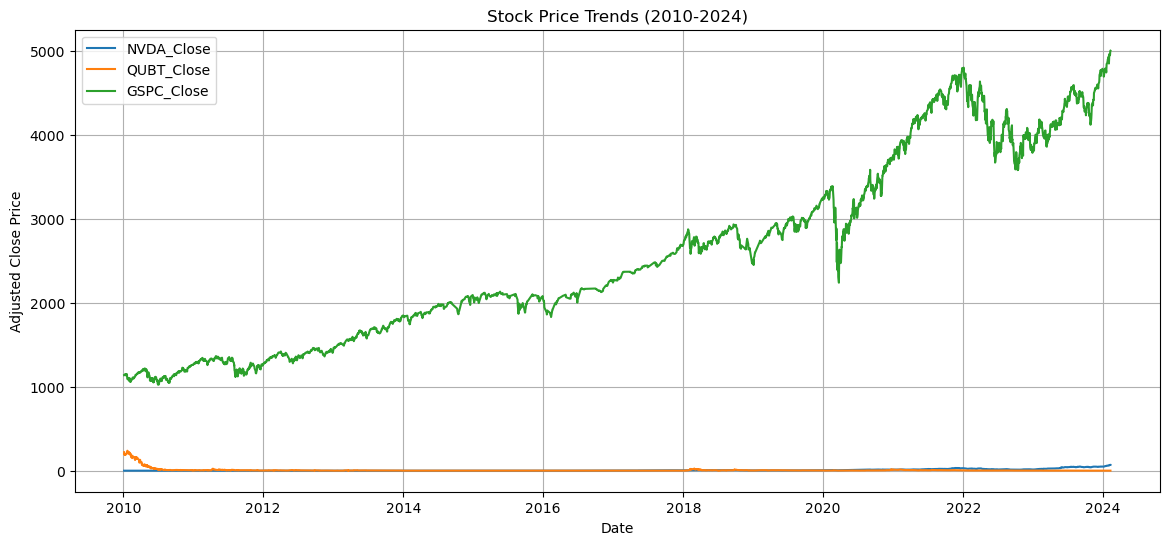

In [30]:
# Plot stock price trends
plt.figure(figsize=(14, 6))
for stock in ["NVDA_Close", "QUBT_Close", "GSPC_Close"]:
    plt.plot(df.index, df[stock], label=stock)

plt.title("Stock Price Trends (2010-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid()
plt.show()

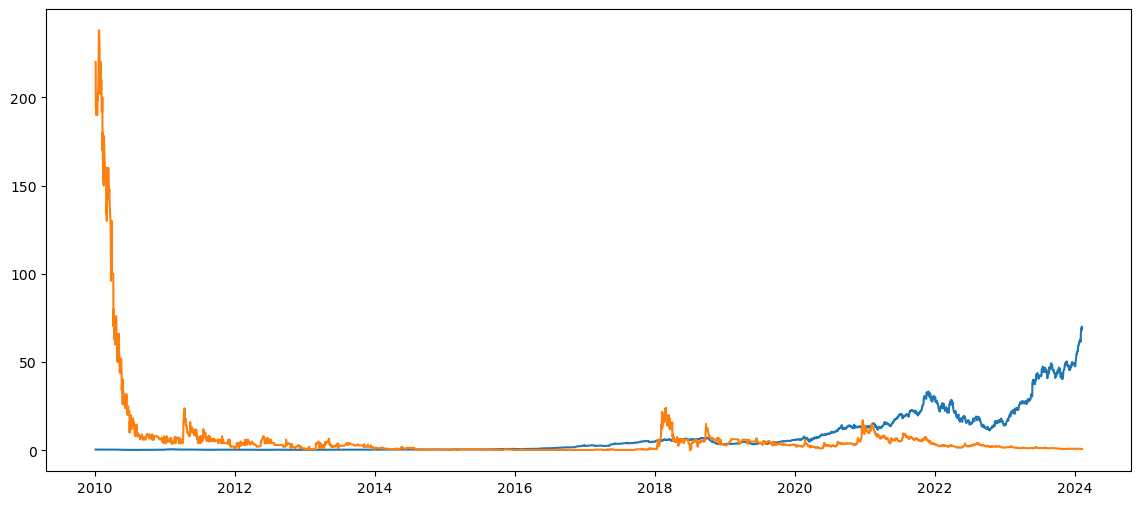

In [31]:
### 1️**Stock Price Trends Over Time**
plt.figure(figsize=(14, 6))
for stock in ["NVDA_Close","QUBT_Close"]:
    plt.plot(df.index, df[stock], label=stock)

 1. NVIDIA (NVDA_Close)
* Massive long-term growth — starting relatively low in 2010 and showing a steep upward trend from around 2016 onwards.

* Especially sharp surges:

  * Around 2016–2018 (initial AI/data center boom).
 
  * 2020–2021: Huge rally during COVID-19 due to gaming, crypto, and AI chip demand.

  * Late 2023–2024: Likely a continued rally driven by AI boom (e.g., ChatGPT, LLMs) and NVDA’s dominance in GPUs.

* Volatility spikes periodically (e.g., early 2022 dip after tech sell-off).


2. Quantum Computing Inc (QUBT_Close)
* Much lower price scale and high volatility.

* Has brief spikes (possibly speculative or hype-driven) but generally remains a penny stock.

* No clear long-term uptrend — mostly fluctuating in a narrow range.


3. S&P 500 Index (^GSPC_Close)
* Steady upward trend with occasional dips:

  * Dip in 2008 (recession) — not visible here but sets the context.

  * 2015–2016: sideways movement.

  * 2020 : COVID-19 crash followed by rapid recovery.

  * 2022: noticeable correction (Fed rate hikes, inflation).

* 2023–2024: Recovery as interest rates stabilize and markets adjust.

### Conclusion

1. NVDA has been a top growth stock. It transitions from a modest performer in 2010 to a market leader by 2024 — reflecting strong fundamentals and innovation cycles.
2. QUBT is speculative and doesn't exhibit consistent growth. It’s likely driven by investor sentiment and announcements rather than fundamentals.
3. S&P 500 Represents broad market health. Gradual growth over time, reflecting the overall positive trajectory of the U.S. economy.

### Daily Returns of NVDA and QUBT overtime

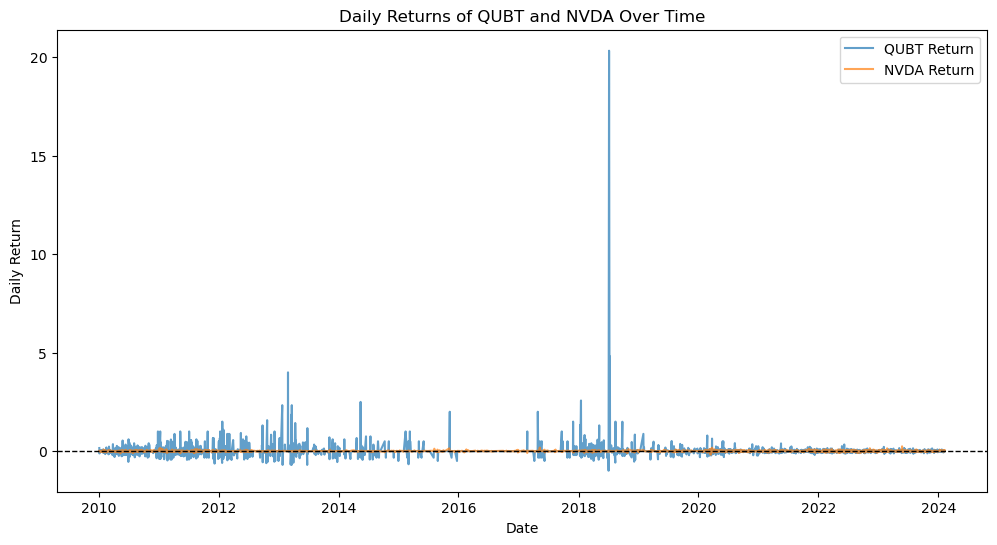

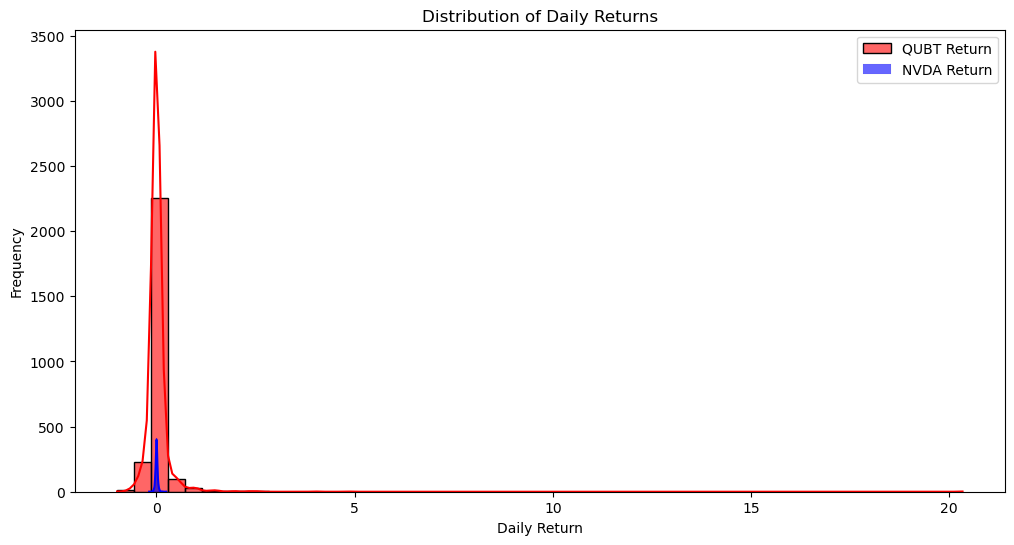

In [86]:
# Load the dataset
df = pd.read_csv("stock_returns_data.csv", index_col="Date", parse_dates=True)

# Plot Time-Series of Returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["QUBT_Close_Return"], label="QUBT Return", alpha=0.7)
plt.plot(df.index, df["NVDA_Close_Return"], label="NVDA Return", alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Daily Returns of QUBT and NVDA Over Time")
plt.legend()
plt.show()

# Histogram of Returns
plt.figure(figsize=(12, 6))
sns.histplot(df["QUBT_Close_Return"], bins=50, kde=True, label="QUBT Return", color="red", alpha=0.6)
sns.histplot(df["NVDA_Close_Return"], bins=50, kde=True, label="NVDA Return", color="blue", alpha=0.6)
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Returns")
plt.legend()
plt.show()

### Observations

The above plots consists of two Visualizations

1.QUBT’s Speculative Nature:

* Its daily returns are highly volatile, likely reflecting speculative buying and selling, possibly driven by hype or announcements.

* Large positive and negative movements suggest the stock’s sensitivity to news or investor sentiment.

2.NVDA’s More Predictable Performance:

* NVDA returns show that the stock has a more predictable performance, which aligns with its reputation as a solid growth stock, especially with the AI sector boost.

* While still volatile, NVDA's price is more consistent, driven by its strong fundamentals in the tech and AI sectors.

3.mpact of Market Events:

* There are sharp movements around particular dates where market events (earnings reports, tech developments, etc.) impact the stocks. These might be visible in both stocks, with QUBT seeing more exaggerated swings compared to NVDA.

### Insights from the Histogram

1. Bimodal Distribution:

* The QUBT return distribution likely shows two peaks, indicating two dominant return behaviors: one for positive returns and one for negative returns.

* Volatility: The histogram will likely be wider, reflecting high volatility, with many extreme returns (both positive and negative).

* Skewness: If the histogram is skewed to the right or left, it suggests that QUBT's returns are not symmetrically distributed and may have more frequent large positive or negative moves.

2.NVDA Return Distribution:
Normal Distribution:

* NVDA’s returns are likely closer to a normal distribution with a central peak around zero returns. This suggests that NVDA’s daily returns tend to hover around a stable mean, with smaller fluctuations.

* Tighter Range: NVDA’s distribution should appear narrower, indicating less volatility compared to QUBT.

3.KDE Curves:
* The KDE curves provide a smoother view of each stock's return distribution. For QUBT, the KDE curve might be more spread out or bi-modal, showing multiple ranges of returns. For NVDA, the KDE curve will likely be narrower, suggesting more consistent and predictable returns.

### Rolling Volatility

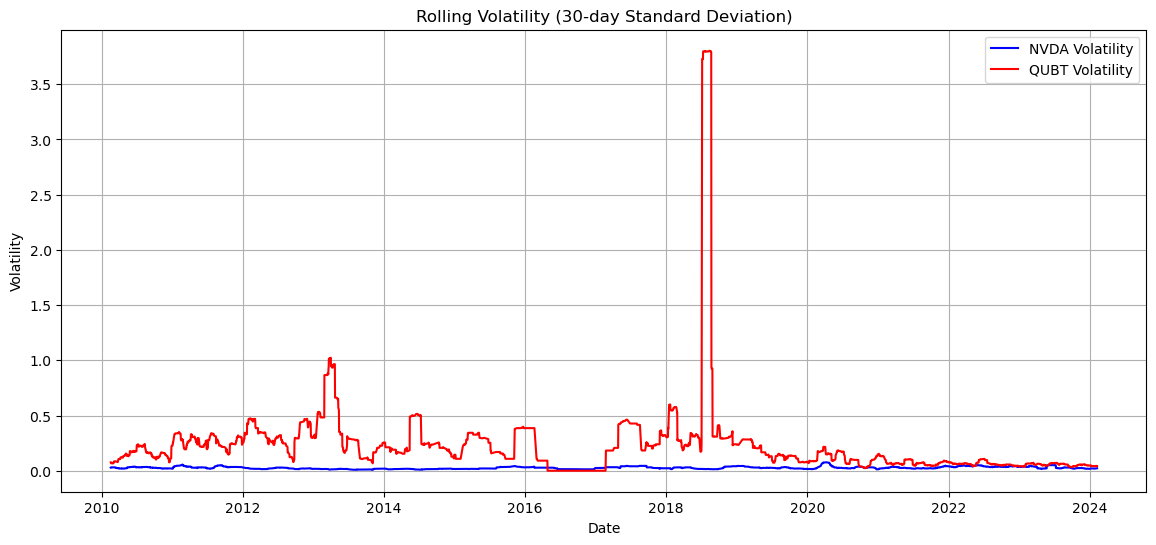

In [38]:
### 3️ **Rolling Volatility (30-day Standard Deviation)**
plt.figure(figsize=(14, 6))
df["NVDA_Rolling_Volatility"] = df["NVDA_Close_Return"].rolling(window=30).std()
df["QUBT_Rolling_Volatility"] = df["QUBT_Close_Return"].rolling(window=30).std()

plt.plot(df.index, df["NVDA_Rolling_Volatility"], label="NVDA Volatility", color="blue")
plt.plot(df.index, df["QUBT_Rolling_Volatility"], label="QUBT Volatility", color="red")

plt.title("Rolling Volatility (30-day Standard Deviation)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid()
plt.show()

### Insight

* Both stocks did not followed similar Trends which means they are not influenced by common market factors
* QUBT shows higher and more erratic volatility while NVDA has lower and more stable volatility.
* In 2018, Quantum Computing Inc.(QUBT) experienced significant volatility, primarily due to a substantial corporate action.
* QUBT shows high rolling volatility this could be as a result of major economic news or industry specific developments.
* NVDA exhibits more stable stable rolling volatility which means good for long-term positioning or portfolio rebalancing.

### Stocks Correlation with S&P 500

In [42]:
print(df.columns)

Index(['NVDA_Close', 'QUBT_Close', 'GSPC_Close', 'NVDA_High', 'QUBT_High',
       'GSPC_High', 'NVDA_Low', 'QUBT_Low', 'GSPC_Low', 'NVDA_Open',
       'QUBT_Open', 'GSPC_Open', 'NVDA_Volume', 'QUBT_Volume', 'GSPC_Volume',
       'NVDA_Close_Return', 'QUBT_Close_Return', 'GSPC_Close_Return',
       'NVDA_High_Return', 'QUBT_High_Return', 'GSPC_High_Return',
       'NVDA_Low_Return', 'QUBT_Low_Return', 'GSPC_Low_Return',
       'NVDA_Open_Return', 'QUBT_Open_Return', 'GSPC_Open_Return',
       'NVDA_Volume_Return', 'QUBT_Volume_Return', 'GSPC_Volume_Return',
       'NVDA_Rolling_Volatility', 'QUBT_Rolling_Volatility'],
      dtype='object')


In [43]:

# Define S&P 500 returns
sp500_returns = df["GSPC_Close_Return"]  # Ensure correct column name

# Compute correlation with S&P 500
correlation_qubt = df["QUBT_Close_Return"].corr(sp500_returns)
correlation_nvda = df["NVDA_Close_Return"].corr(sp500_returns)

# Compute Beta for QUBT
beta_qubt = np.cov(df["QUBT_Close_Return"].dropna(), sp500_returns.dropna())[0, 1] / np.var(sp500_returns.dropna())

# Compute Beta for NVDA
beta_nvda = np.cov(df["NVDA_Close_Return"].dropna(), sp500_returns.dropna())[0, 1] / np.var(sp500_returns.dropna())

# Display results
print("Correlation with S&P 500:")
print(f"QUBT: {correlation_qubt:.4f}")
print(f"NVDA: {correlation_nvda:.4f}")

print("\nBeta Values:")
print(f"QUBT: {beta_qubt:.4f}")
print(f"NVDA: {beta_nvda:.4f}")

Correlation with S&P 500:
QUBT: 0.0343
NVDA: 0.6585

Beta Values:
QUBT: 1.3608
NVDA: 1.6248


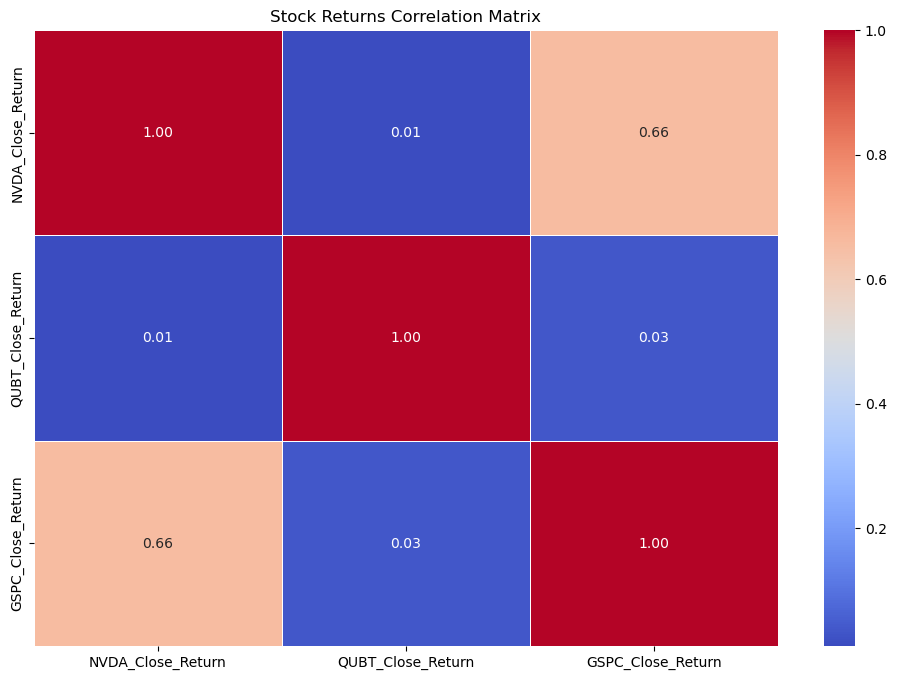

In [44]:
# Define relevant columns for correlation
returns_columns = ["NVDA_Close_Return", "QUBT_Close_Return", "GSPC_Close_Return"]

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[returns_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Stock Returns Correlation Matrix")
plt.show()

### Observations

The values provided indicate how NVDA and QUBT move relative to the S&P 500 index(^GSPC) which is a Benchmark for the overall market.
* NVDA:0.6585
* QUBT:0.0343
* NVDA with 0.6585 has a moderate to strong positive correlation with the S&P 500 and it tends to move in line with the market trends, meaning it's influenced by overall economic conditions, tech sector trends, and investor sentiment.
* QUBT with 0.0343 has very low correlation with the S&P 500 which suggests it does not move with the broader market, meaning its price is driven by company-specific or niche-sector news
* NVDA Beta = 1.6248
* QUBT Beta = 1.3608
* NVDA is more valatile than the market, but also correlated - this is a true high-beta stock.Higher beta, higher potential reward, but also higher risk during downturns.
* QUBT moves in the same direction as S&P 500. However, since the correlation is near zero, the beta is less meaningful, the high beta could be statistical noise and not true market sensitivity

### Dynamic Visualizations to showcase Pricing Trends, Sector impacts, and Financial Health.


In [48]:
# Initialize Dash app
app = dash.Dash(__name__)

# Load stock data (ensure you have a DataFrame named 'stock_data')
# stock_data = pd.read_csv("your_stock_data.csv")  # Uncomment and modify if needed

# Available stock options
available_stocks = ["QUBT", "NVDA", "GSPC"]

# Layout
app.layout = html.Div([
    html.H1("Stock Market Trends & Financial Health", style={"text-align": "center"}),

    # Dropdown to select stock
    dcc.Dropdown(
        id="stock_selector",
        options=[{"label": stock, "value": stock} for stock in available_stocks],
        value="NVDA",  # Default selection
        multi=False,
        style={"width": "50%", "margin": "auto"}
    ),

    # Graphs
    dcc.Graph(id="price_chart"),
    dcc.Graph(id="returns_histogram"),
    dcc.Graph(id="correlation_heatmap"),
])

# Callbacks for updating charts
@app.callback(
    [Output("price_chart", "figure"),
     Output("returns_histogram", "figure"),
     Output("correlation_heatmap", "figure")],
    [Input("stock_selector", "value")]
)
def update_charts(selected_stock):
    if selected_stock not in stock_data.columns:
        return px.line(title="Stock data not available"), px.histogram(title="No data"), px.imshow(title="No data")

    # Price Trend Chart
    fig_price = px.line(
        stock_data, x=stock_data.index, y=selected_stock,
        title=f"Price Trends for {selected_stock}",
        labels={"x": "Date", "y": "Stock Price"},
        template="plotly_dark"
    )

    # Returns Distribution (Volatility)
    fig_returns = px.histogram(
        stock_data, x=f"{selected_stock}_Return", nbins=50,
        title=f"Returns Distribution for {selected_stock}",
        template="plotly_dark"
    )

    # Correlation Heatmap for Sector Impacts
    sector_stocks = ["QUBT_Close_Return", "NVDA_Close_Return", "GSPC_Close_Return"]
    correlation_matrix = stock_data[sector_stocks].corr()
    fig_correlation = px.imshow(
        correlation_matrix, text_auto=True, title="Stock Returns Correlation Heatmap",
        labels={"color": "Correlation"}, template="plotly_dark"
    )

    return fig_price, fig_returns, fig_correlation

# Run app
if __name__ == "__main__":
    app.run(debug=True)  # Corrected the method

In [49]:
!pip install gunicorn

### Comparative Analysis

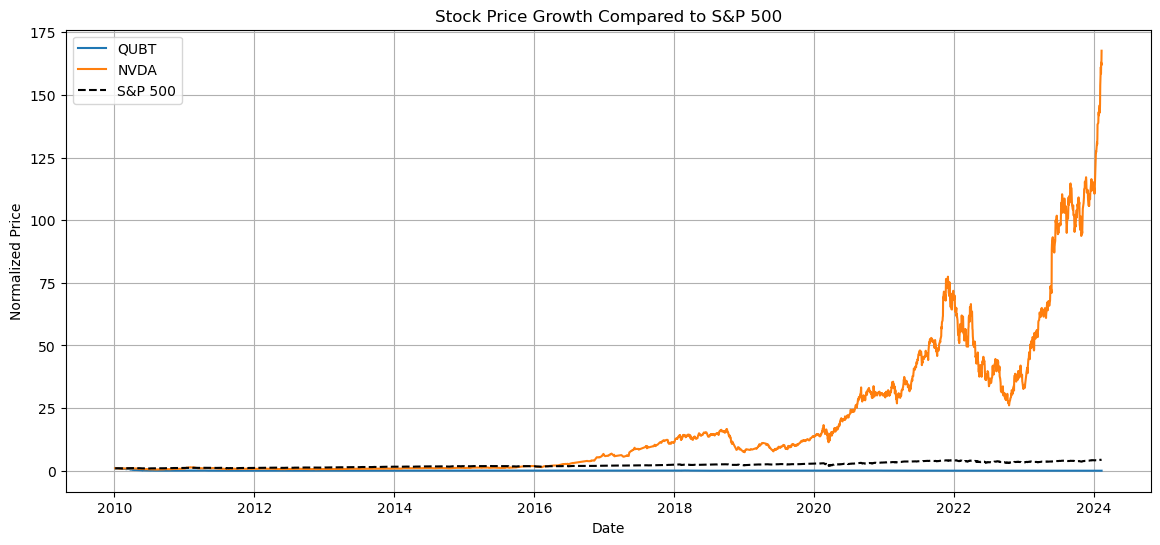

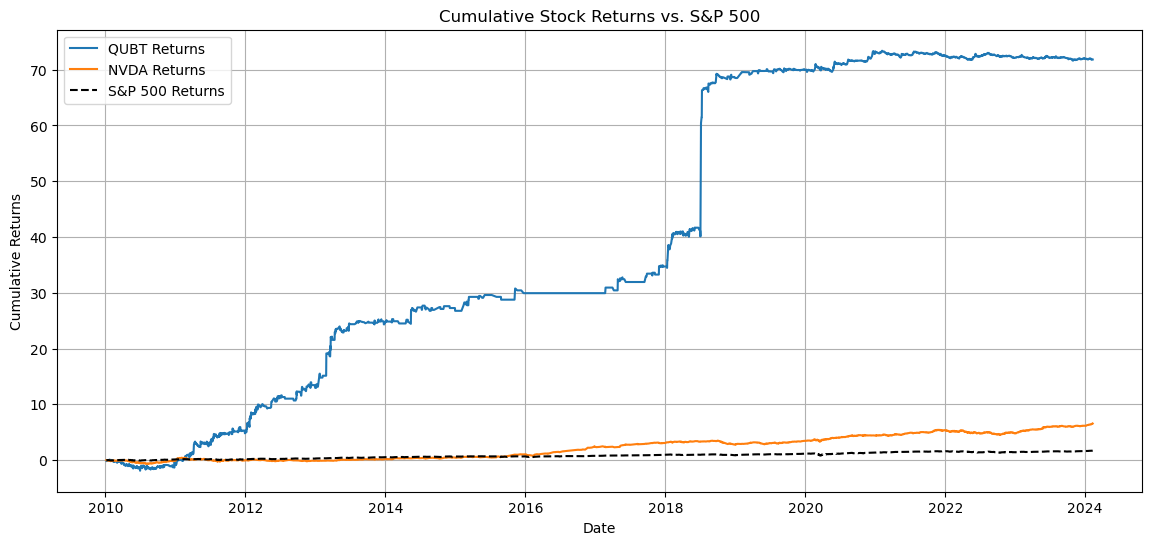

C:\Users\Omast\AppData\Local\Temp\ipykernel_4888\125699157.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




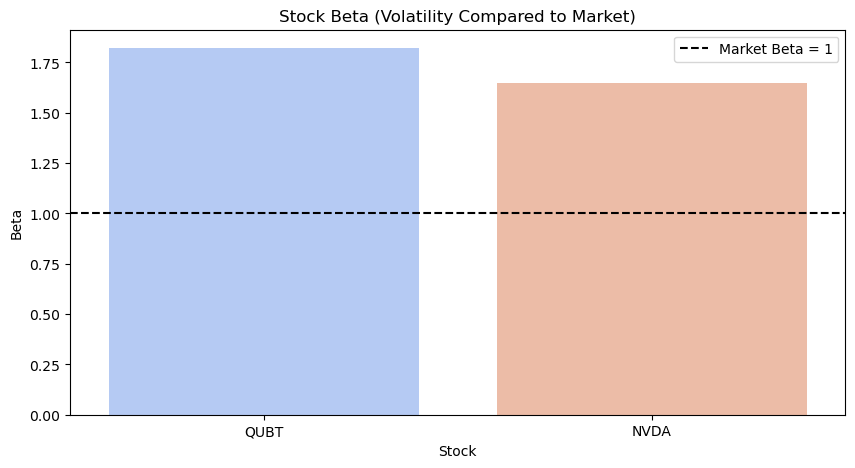

In [51]:
# Ensure you have your stock_data in the appropriate format
# stock_data should be a DataFrame with columns like KO_Close, PEP_Close, GSPC_Close, etc.

# List of stocks to compare
stocks = ["QUBT", "NVDA"]
market_index = "GSPC"  # Correct column name for S&P 500 Index

# Calculate daily returns for each stock and the market index
df['QUBT_Return'] = df['QUBT_Close'].pct_change()
df['NVDA_Return'] = df['NVDA_Close'].pct_change()
df['GSPC_Return'] = df['GSPC_Close'].pct_change()

# 1️. **Stock Price Growth vs. Market Index**
plt.figure(figsize=(14, 6))
for stock in stocks:
    # Corrected column names here (KO_Close and PEP_Close)
    plt.plot(df.index, df[f"{stock}_Close"] / df[f"{stock}_Close"].iloc[0], label=stock)
    
# Corrected column name for the market index (GSPC_Close)
plt.plot(df.index, df[f"{market_index}_Close"] / df[f"{market_index}_Close"].iloc[0], label="S&P 500", linestyle="dashed", color="black")

plt.title("Stock Price Growth Compared to S&P 500")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid()
plt.show()

# 2️. **Stock Returns vs. Market Returns (Cumulative)**
plt.figure(figsize=(14, 6))
for stock in stocks:
    plt.plot(df.index, df[f"{stock}_Return"].cumsum(), label=f"{stock} Returns")

# Corrected column name for the market index returns (GSPC_Return)
plt.plot(df.index, df[f"{market_index}_Return"].cumsum(), label="S&P 500 Returns", linestyle="dashed", color="black")

plt.title("Cumulative Stock Returns vs. S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

# 3️. **Stock Beta (Volatility Compared to Market)**
betas = {}
for stock in stocks:
    # Covariance and variance calculation using the correct return columns
    covariance = np.cov(df[f"{stock}_Return"].dropna(), df[f"{market_index}_Return"].dropna())[0, 1]
    market_variance = np.var(df[f"{market_index}_Return"].dropna())
    betas[stock] = covariance / market_variance

# Convert to DataFrame for visualization
beta_df = pd.DataFrame(list(betas.items()), columns=["Stock", "Beta"])
plt.figure(figsize=(10, 5))
sns.barplot(x="Stock", y="Beta", data=beta_df, palette="coolwarm")
plt.axhline(y=1, linestyle="dashed", color="black", label="Market Beta = 1")
plt.title("Stock Beta (Volatility Compared to Market)")
plt.legend()
plt.show()

### Insight

1.The stock price growth compared to S&P 500 gives a visual comparison of growth over time.
* NVDA curve rises above the S&P 500 line, shows it outperformed the market or reflecting strong Tech growth.
* QUBT underperformed because the curve is below the market line meaning being more speculative and show more irregular growth.

2. Cumulative Returns vs S&P500
* NVDA likely shows a consistent upward trend with some volatility.

* QUBT may show flat, choppy, or steep jumps, depending on speculative movements.

3. Stock Beta (Volatility Compared to Market)
* NVDA shows high beta, confirming it is a market-sensitive growth stock — great in bull markets, risky in bear markets.

* QUBT shows also high beta, but its low correlation (from earlier) implies:

* The high beta might be statistical noise, not actual market tracking.

* QUBT is volatile but unpredictable, driven more by idiosyncratic factors.

### Comparing Stock Volatility

[*********************100%***********************]  3 of 3 completed


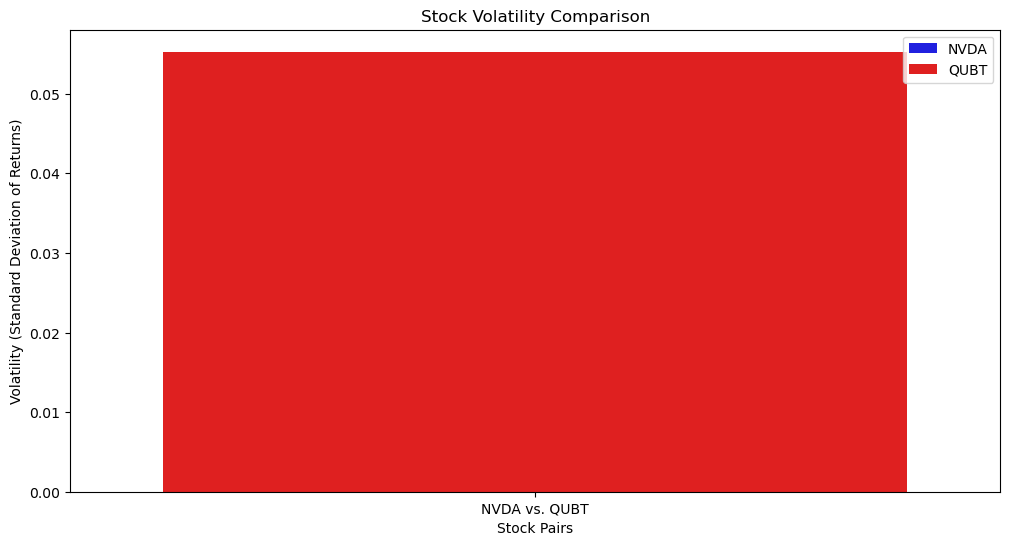

Comparative Analysis of Stocks Based on Volatility & Suitability for Investment:
      Stock Pair Stock 1 Stock 2  Volatility 1  Volatility 2    Beta 1  \
0  NVDA vs. QUBT    NVDA    QUBT      0.030525      0.055285  2.048273   

     Beta 2  Sharpe Ratio 1  Sharpe Ratio 2  
0  2.168558        0.178275       -0.009861  
Based on risk-adjusted return (Sharpe Ratio), NVDA is the better investment option.


In [55]:
# Define the stocks and market index
primary_stock = 'NVDA'
competitor_stock = 'QUBT'
market_index = '^GSPC'  # S&P 500 as the market benchmark
stocks = [primary_stock, competitor_stock, market_index]

# Fetch historical data
start_date = '2023-01-01'
end_date = '2024-01-01'

# Download stock price data
data = yf.download(stocks, start=start_date, end=end_date)['Close']

# Ensure market index is in the dataset
if market_index not in data.columns:
    print(f"Warning: Market index {market_index} data not found. Excluding from analysis.")
    data = data[[primary_stock, competitor_stock]]

# Handle missing data by filling with the median value of the column
data.fillna(data.median(), inplace=True)

# Calculate daily returns
data_returns = data.pct_change().dropna()
data_returns.columns = [f"{col}_Return" for col in data_returns.columns]

# Join the returns to the price data
data = data.join(data_returns, how='left')

# Define stock pairs for comparison
stock_pairs = [(primary_stock, competitor_stock)]

# Store results
results = []

# Loop through stock pairs to calculate performance metrics
for stock1, stock2 in stock_pairs:
    # Volatility (Standard Deviation of returns)
    stock1_volatility = data[f"{stock1}_Return"].std()
    stock2_volatility = data[f"{stock2}_Return"].std()
    
    # Beta (Market Sensitivity)
    covariance1 = np.cov(data[f"{stock1}_Return"].dropna(), data[f"{market_index}_Return"].dropna())[0, 1]
    beta1 = covariance1 / np.var(data[f"{market_index}_Return"].dropna())
    
    covariance2 = np.cov(data[f"{stock2}_Return"].dropna(), data[f"{market_index}_Return"].dropna())[0, 1]
    beta2 = covariance2 / np.var(data[f"{market_index}_Return"].dropna())
    
    # Sharpe Ratio (Risk-Adjusted Return)
    stock1_sharpe = data[f"{stock1}_Return"].mean() / stock1_volatility
    stock2_sharpe = data[f"{stock2}_Return"].mean() / stock2_volatility
    
    results.append({
        "Stock Pair": f"{stock1} vs. {stock2}",
        "Stock 1": stock1,
        "Stock 2": stock2,
        "Volatility 1": stock1_volatility,
        "Volatility 2": stock2_volatility,
        "Beta 1": beta1,
        "Beta 2": beta2,
        "Sharpe Ratio 1": stock1_sharpe,
        "Sharpe Ratio 2": stock2_sharpe
    })

# Convert results into a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Visualize Volatility Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Stock Pair", y="Volatility 1", data=results_df, color="blue", label=primary_stock)
sns.barplot(x="Stock Pair", y="Volatility 2", data=results_df, color="red", label=competitor_stock)
plt.title("Stock Volatility Comparison")
plt.xlabel("Stock Pairs")
plt.ylabel("Volatility (Standard Deviation of Returns)")
plt.legend()
plt.show()

# Print out the detailed analysis
print("Comparative Analysis of Stocks Based on Volatility & Suitability for Investment:")
print(results_df)

# Recommendation based on Sharpe Ratio (higher Sharpe Ratio is better)
best_stock = primary_stock if results_df["Sharpe Ratio 1"].values[0] > results_df["Sharpe Ratio 2"].values[0] else competitor_stock
print(f"Based on risk-adjusted return (Sharpe Ratio), {best_stock} is the better investment option.")

### Insight

1. Volatility Comparison
QUBT has higher volatility than NVDA (0.055 vs. 0.030).

* This implies greater price swings, which may lead to higher short-term gains or losses.

* NVDA is more stable, making it more suitable for risk-conscious investor.

2. Beta (Market Sensitivity)
* Both stocks have high betas (>2), meaning they are more volatile than the market.

* This suggests both are amplified versions of market moves:

* If the market rises, these stocks may rise more.

* If the market drops, expect bigger drops.

QUBT’s beta is slightly higher, indicating even more extreme reactions to market changes — though earlier correlation analysis showed its movements are often less predictabl.

3. Sharpe Ratio (Risk-Adjusted Return)
* NVDA's Sharpe Ratio = 0.1783:

* A positive Sharpe Ratio indicates it delivers excess return per unit of risk.

* Not exceptional, but acceptable in a volatile environment.

* QUBT's Sharpe Ratio = -0.0099:

* Negative Sharpe implies the risk taken is not justified by returns.

* Investors are taking on risk without getting compensated, which is a red flag for long-term holding.

### Conclusion

1. NVDA is the better investment option, based on:

 * Lower volatility,

 * More consistent performance,

 * Positive risk-adjusted return.

2. QUBT is highly speculative:

 * While it may offer large upside potential in short bursts, it does not reward risk appropriately (as seen in its negative Sharpe Ratio).

 * Best suited for short-term trades, speculation, or portfolio diversification, not as a core holding.


### Financial Analysis

C:\Users\Omast\AppData\Local\Temp\ipykernel_4888\3023958129.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




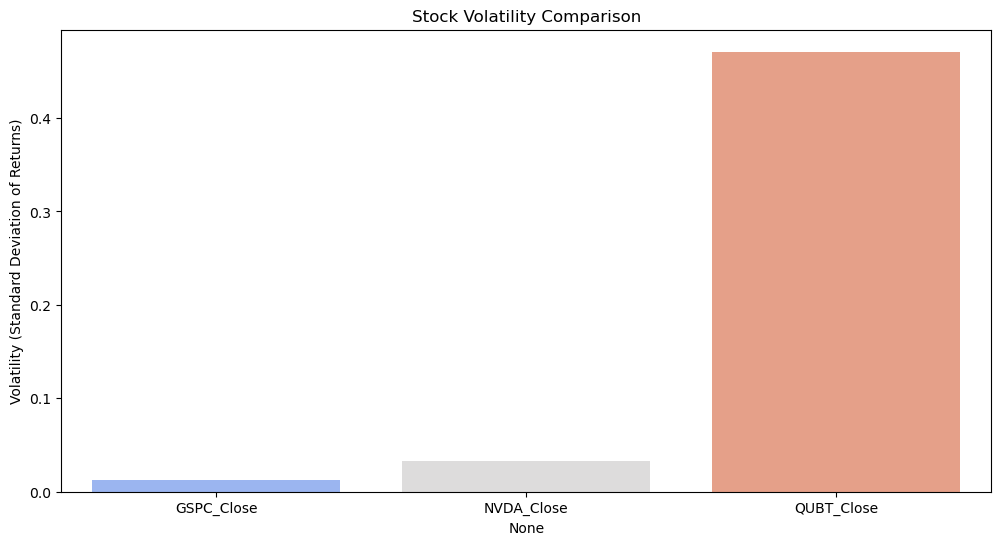

C:\Users\Omast\AppData\Local\Temp\ipykernel_4888\3023958129.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




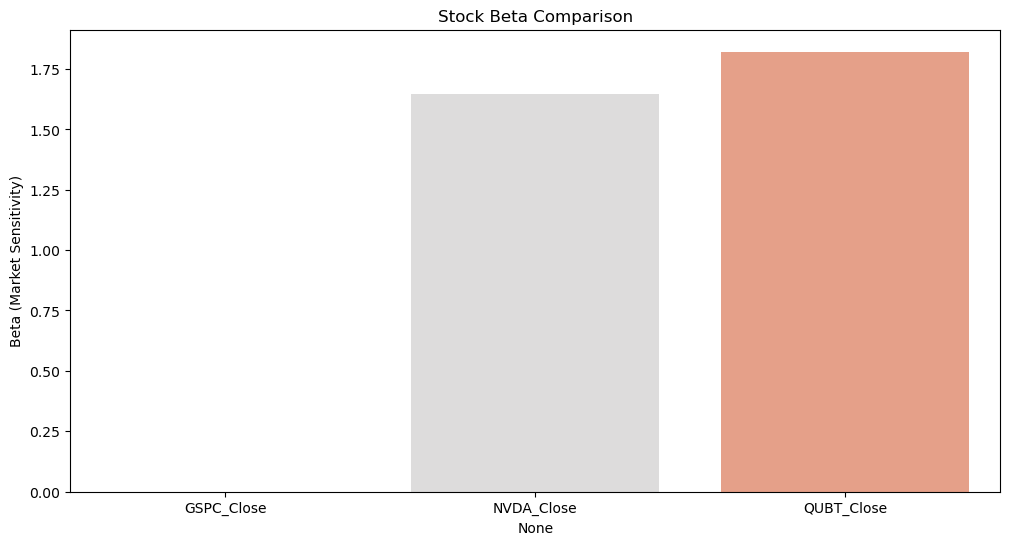

C:\Users\Omast\AppData\Local\Temp\ipykernel_4888\3023958129.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




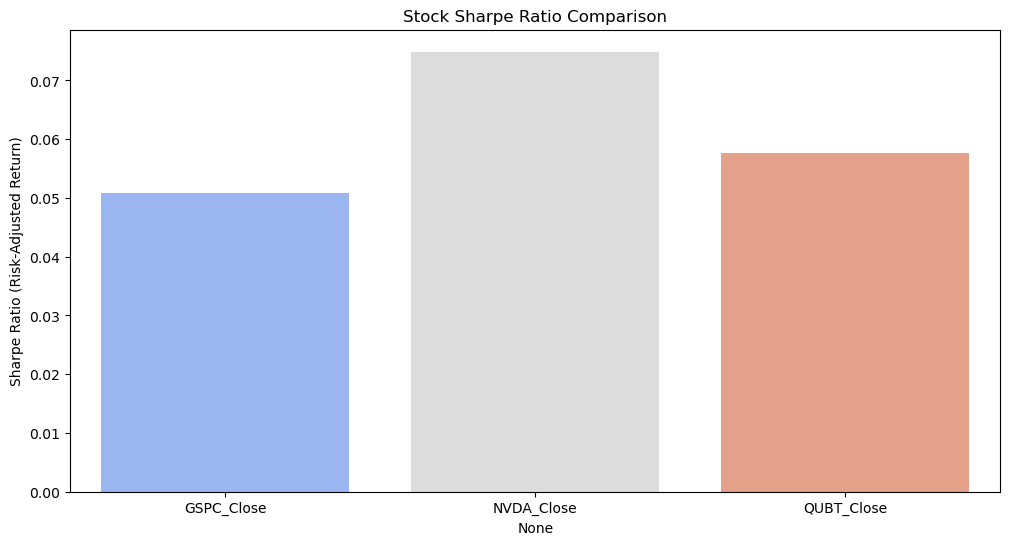

Analysis complete. Results saved to 'financial_metrics_summary.csv'.


In [61]:
file_path = 'stock_returns_data.csv'  # Update with actual file path
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Select relevant columns
stocks = ['QUBT_Close', 'NVDA_Close', 'GSPC_Close']
data = data[stocks]

# Calculate daily returns
data_returns = data.pct_change().dropna()

# Compute key financial metrics
volatility = data_returns.std()
sharpe_ratio = data_returns.mean() / volatility

# Compute Beta (Market Sensitivity)
market_returns = data_returns['GSPC_Close']
betas = {}
for stock in ['QUBT_Close', 'NVDA_Close']:
    covariance = np.cov(data_returns[stock], market_returns)[0, 1]
    beta = covariance / np.var(market_returns)
    betas[stock] = beta

# Convert results into DataFrame
metrics_df = pd.DataFrame({'Volatility': volatility, 'Sharpe Ratio': sharpe_ratio, 'Beta': betas})

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Volatility'], palette='coolwarm')
plt.title('Stock Volatility Comparison')
plt.ylabel('Volatility (Standard Deviation of Returns)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Beta'], palette='coolwarm')
plt.title('Stock Beta Comparison')
plt.ylabel('Beta (Market Sensitivity)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Sharpe Ratio'], palette='coolwarm')
plt.title('Stock Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio (Risk-Adjusted Return)')
plt.show()

# Save results
metrics_df.to_csv('financial_metrics_summary.csv')
print("Analysis complete. Results saved to 'financial_metrics_summary.csv'.")


[*********************100%***********************]  3 of 3 completed
C:\Users\Omast\AppData\Local\Temp\ipykernel_4888\1037995125.py:47: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




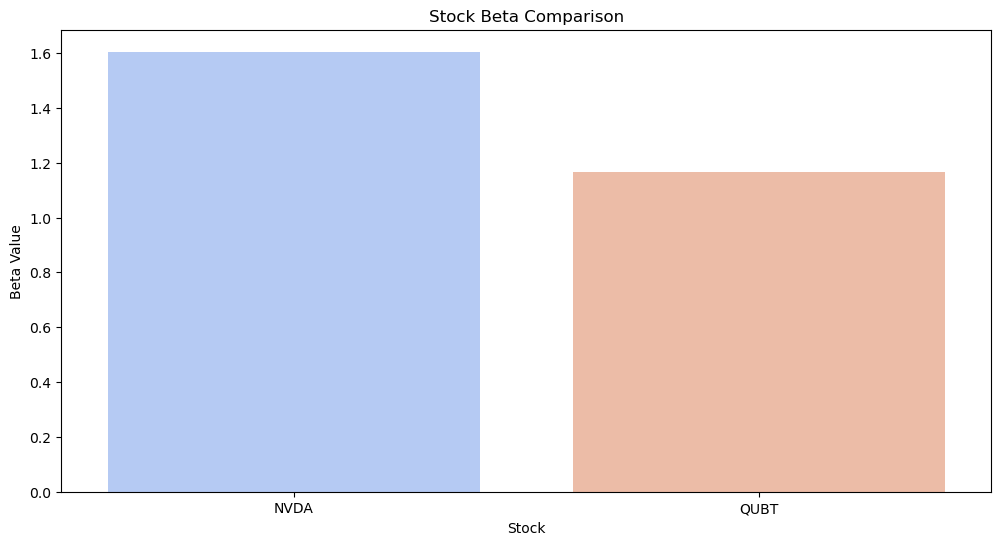

Financial Performance Metrics:
  Stock  Volatility  Sharpe Ratio      Beta
0  NVDA    0.028274      0.061847  1.604592
1  QUBT    0.408065      0.050218  1.167376


In [62]:
# Define stock symbols
primary_stock = 'NVDA'  # PepsiCo
competitor_stock = 'QUBT'  # Coca-Cola
market_index = '^GSPC'  # S&P 500 as benchmark
stocks = [primary_stock, competitor_stock, market_index]

# Fetch historical data
start_date = '2010-01-01'
end_date = '2024-01-01'
data = yf.download(stocks, start=start_date, end=end_date)['Close']

# Handle missing values by filling with median
data.fillna(data.median(), inplace=True)

# Calculate daily returns
data_returns = data.pct_change().dropna()
data_returns.columns = [f"{col}_Return" for col in data_returns.columns]

# Merge returns back into the dataset
data = data.join(data_returns, how='left')

# Store calculated metrics
metrics = []

# Calculate key performance indicators for each stock
for stock in [primary_stock, competitor_stock]:
    volatility = data[f"{stock}_Return"].std()
    sharpe_ratio = data[f"{stock}_Return"].mean() / volatility
    covariance = np.cov(data[f"{stock}_Return"].dropna(), data[f"{market_index}_Return"].dropna())[0, 1]
    beta = covariance / np.var(data[f"{market_index}_Return"].dropna())
    
    metrics.append({
        "Stock": stock,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Beta": beta
    })

# Convert results to DataFrame
metrics_df = pd.DataFrame(metrics)

# Save results
metrics_df.to_csv('financial_analysis_results.csv', index=False)

# Visualize results
plt.figure(figsize=(12, 6))
sns.barplot(x="Stock", y="Beta", data=metrics_df, palette="coolwarm")
plt.title("Stock Beta Comparison")
plt.ylabel("Beta Value")
plt.show()

# Print results
print("Financial Performance Metrics:")
print(metrics_df)


[*********************100%***********************]  3 of 3 completed


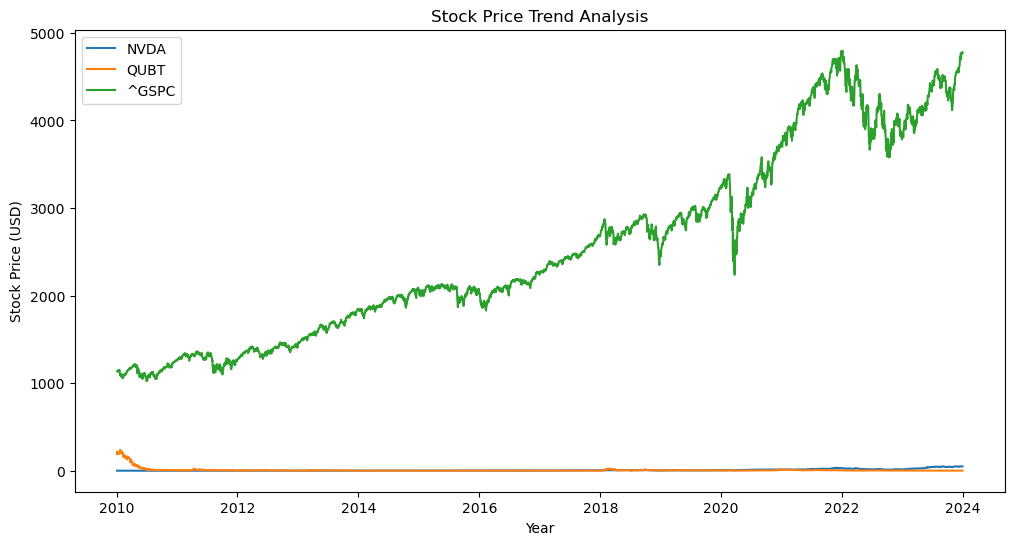

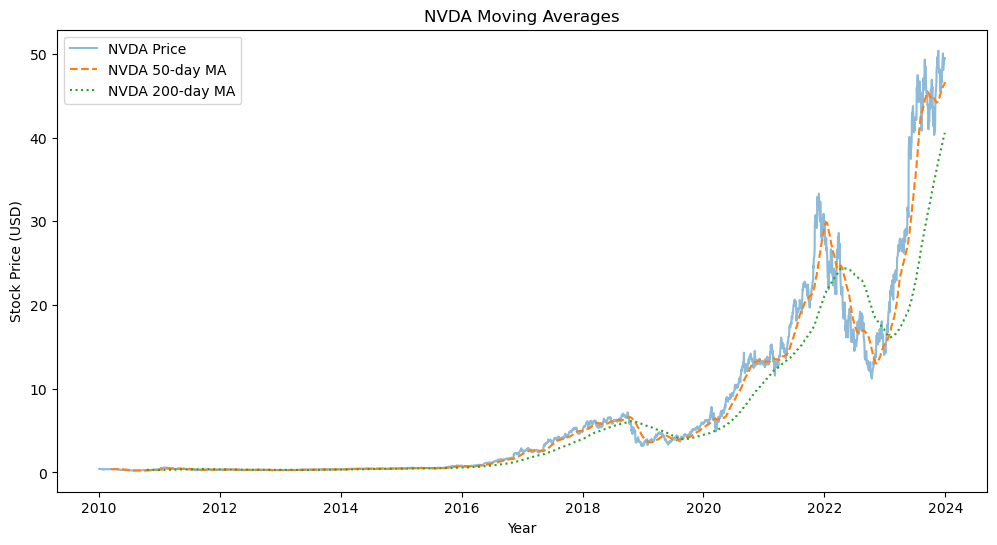

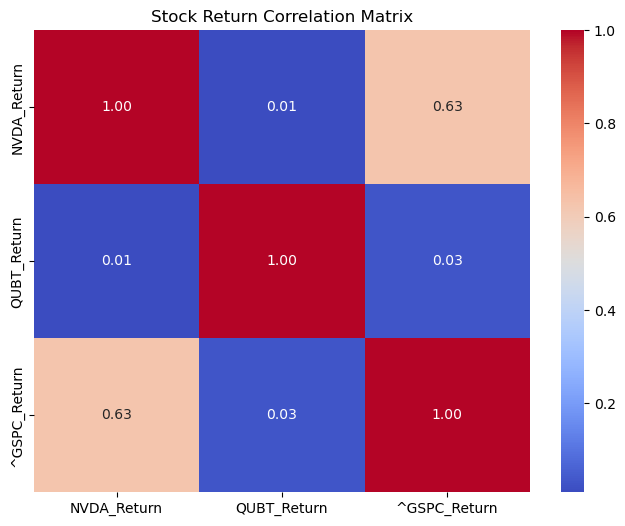

Stock Return Correlation Matrix:
              NVDA_Return  QUBT_Return  ^GSPC_Return
NVDA_Return      1.000000     0.009588      0.626018
QUBT_Return      0.009588     1.000000      0.031557
^GSPC_Return     0.626018     0.031557      1.000000

Top Correlated Stocks:
NVDA_Return   ^GSPC_Return    0.626018
^GSPC_Return  NVDA_Return     0.626018
QUBT_Return   ^GSPC_Return    0.031557
dtype: float64


In [63]:
# Define stocks and market index
primary_stock = 'NVDA'
competitor_stock = 'QUBT'
market_index = '^GSPC'  # S&P 500 as the market benchmark
stocks = [primary_stock, competitor_stock, market_index]

# Fetch historical data
start_date = '2010-01-01'
end_date = '2024-01-01'
data = yf.download(stocks, start=start_date, end=end_date)['Close']

# Calculate daily returns
data_returns = data.pct_change().dropna()
data_returns.columns = [f"{col}_Return" for col in data_returns.columns]

# Trend Analysis: Plot stock prices over time
plt.figure(figsize=(12, 6))
for stock in [primary_stock, competitor_stock, market_index]:
    plt.plot(data[stock], label=stock)
plt.title("Stock Price Trend Analysis")
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

# Moving Averages (50-day & 200-day)
data[f"{primary_stock}_50MA"] = data[primary_stock].rolling(window=50).mean()
data[f"{primary_stock}_200MA"] = data[primary_stock].rolling(window=200).mean()

data[f"{competitor_stock}_50MA"] = data[competitor_stock].rolling(window=50).mean()
data[f"{competitor_stock}_200MA"] = data[competitor_stock].rolling(window=200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(data[primary_stock], label=f"{primary_stock} Price", alpha=0.5)
plt.plot(data[f"{primary_stock}_50MA"], label=f"{primary_stock} 50-day MA", linestyle='dashed')
plt.plot(data[f"{primary_stock}_200MA"], label=f"{primary_stock} 200-day MA", linestyle='dotted')
plt.title(f"{primary_stock} Moving Averages")
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

# Correlation Analysis
correlation_matrix = data_returns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Stock Return Correlation Matrix")
plt.show()

# Print correlation insights
print("Stock Return Correlation Matrix:")
print(correlation_matrix)

# Identify strongest relationships
highest_correlation = correlation_matrix.unstack().sort_values(ascending=False)
highest_correlation = highest_correlation[highest_correlation < 1]  # Remove self-correlation
print("\nTop Correlated Stocks:")
print(highest_correlation.head(3))


### Modelling and Evaluation

We will now build two models to predict Stock Direction (Up = 1, Down = 0):

XGBoost (Gradient Boosting ML Model)

LSTM (Deep Learning Model)

Steps for Modeling & Evaluation

️1.Prepare Data → Feature selection, Train-Test Split (80:20)

️2. Train XGBoost Model → Classical ML approach

️3. Train LSTM Model → Deep Learning approach

️4. Evaluate Models → Accuracy, Precision, Recall, F1-Score

### Data Preparation

In [67]:
print(df.columns)
print(type(df.columns))

Index(['NVDA_Close', 'QUBT_Close', 'GSPC_Close', 'NVDA_High', 'QUBT_High',
       'GSPC_High', 'NVDA_Low', 'QUBT_Low', 'GSPC_Low', 'NVDA_Open',
       'QUBT_Open', 'GSPC_Open', 'NVDA_Volume', 'QUBT_Volume', 'GSPC_Volume',
       'NVDA_Close_Return', 'QUBT_Close_Return', 'GSPC_Close_Return',
       'NVDA_High_Return', 'QUBT_High_Return', 'GSPC_High_Return',
       'NVDA_Low_Return', 'QUBT_Low_Return', 'GSPC_Low_Return',
       'NVDA_Open_Return', 'QUBT_Open_Return', 'GSPC_Open_Return',
       'NVDA_Volume_Return', 'QUBT_Volume_Return', 'GSPC_Volume_Return',
       'NVDA_Rolling_Volatility', 'QUBT_Rolling_Volatility', 'QUBT_Return',
       'NVDA_Return', 'GSPC_Return'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>


In [68]:
# Extract Close prices
df_close = df['Close'].copy()

# Drop rows with missing values
df_close.dropna(inplace=True)

# Create NVDA direction column
df_close['NVDA_Direction'] = np.where(df_close['NVDA'].shift(-1) > df_close['NVDA'], 1, 0)

# Drop last row due to shift
df_close.dropna(inplace=True)

# Save
df_close.to_csv("stock_with_nvda_direction.csv")

KeyError: 'Close'

In [ ]:
print(data.columns.tolist())

In [ ]:
# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Create tomorrow's price and direction
df['NVDA_Tomorrow'] = df['NVDA_Close'].shift(-1)
df['NVDA_Direction'] = (df['NVDA_Tomorrow'] > df['NVDA_Close']).astype(int)

# Drop NaNs from the shift
df.dropna(subset=['NVDA_Direction'], inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import mlflow.sklearn

# STEP 1: Define features and target
xgb_features_nvda = ['NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume']
xgb_target_nvda = 'NVDA_Direction'

# STEP 2: Prepare dataset
df_model_xgb = df.dropna(subset=xgb_features_nvda + [xgb_target_nvda]).copy()
X_nvda_xgb = df_model_xgb[xgb_features_nvda]
y_nvda_xgb = df_model_xgb[xgb_target_nvda]

# STEP 3: Train-test split (80/20, no shuffle)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_nvda_xgb, y_nvda_xgb, test_size=0.2, shuffle=False)

# STEP 4: Train base model
xgb_model_nvda = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_nvda.fit(X_train_xgb, y_train_xgb)

In [ ]:
# STEP 5: Predict and evaluate
xgb_direction_pred = xgb_model_nvda.predict(X_test_xgb)
xgb_accuracy = accuracy_score(y_test_xgb, xgb_direction_pred)

# STEP 6: Log to MLflow
# Use one row from X_test as example
input_example_xgb = X_test_xgb.iloc[:1]

if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="XGBoost_Base_nvda"):
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_metric("accuracy", xgb_accuracy)

    # Fix the warning by including input_example
    mlflow.sklearn.log_model(
        xgb_model_nvda,
        artifact_path="xgb_model_nvda",
        input_example=input_example_xgb
    )

print(f"XGBoost Model Accuracy: {xgb_accuracy:.2%}")

In [ ]:
X = dummy_df.drop('NVDA_Direction',axis=1)      # Features
y = dummy_df['NVDA_Direction']  # Labels (Target Variable)

In [ ]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

In [ ]:
pep_data = yf.download("PEP", start=start_date, end=end_date)[['Close']]
ko_data = yf.download("KO", start=start_date, end=end_date)[['Close']]

# Feature Engineering
def create_features(data):
    data['Return'] = data['Close'].pct_change()
    data['5_MA'] = data['Close'].rolling(window=5).mean()
    data['20_MA'] = data['Close'].rolling(window=20).mean()
    data['Volatility'] = data['Return'].rolling(window=10).std()
    data.dropna(inplace=True)
    return data

pep_data = create_features(pep_data)
ko_data = create_features(ko_data)

# Train-test split
X_pep, y_pep = pep_data.drop(columns=['Close']), pep_data['Close']
X_train_pep, X_test_pep, y_train_pep, y_test_pep = train_test_split(X_pep, y_pep, test_size=0.2, shuffle=False)

X_ko, y_ko = ko_data.drop(columns=['Close']), ko_data['Close']
X_train_ko, X_test_ko, y_train_ko, y_test_ko = train_test_split(X_ko, y_ko, test_size=0.2, shuffle=False)


### Train & Log XGBoost with mlflow

In [ ]:
def train_xgboost(X_train, X_test, y_train, y_test, stock_name):
    with mlflow.start_run(run_name=f"XGBoost_{stock_name}"):
        model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)

        # Log parameters & metrics
        mlflow.log_param("model", "XGBoost")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("learning_rate", 0.1)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2_Score", r2)

        # Log model
        mlflow.sklearn.log_model(model, f"XGBoost_Model_{stock_name}")

        print(f"XGBoost {stock_name} - RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

# Train XGBoost for PEP & KO
train_xgboost(X_train_pep, X_test_pep, y_train_pep, y_test_pep, "PEP")
train_xgboost(X_train_ko, X_test_ko, y_train_ko, y_test_ko, "KO")


### Insight

1. XGBoost Model for PEP (PepsiCo)
* RMSE: 30.8155 → The average prediction error is 30.82 units (likely % return or price).

* R² Score: -3.8135 → The model performs much worse than just using the mean return (high negative R² suggests poor predictive power).

2. XGBoost Model for KO (Coca-Cola)
* RMSE: 5.6153 → The average prediction error is 5.62 units.

*  Score: -1.0739 → Still negative, meaning the model performs worse than a simple mean-based prediction.             

### Conclusion

* The XGBoost model for PepsiCo is highly unreliable. It fails to capture any meaningful trend and is making large prediction errors.
* The Coca-Cola model is slightly better than the PepsiCo model (lower RMSE), but it still performs worse than random guessing.

### Train & Log LSTM with mlflow

In [ ]:
def train_lstm(X_train, X_test, y_train, y_test, stock_name):
    with mlflow.start_run(run_name=f"LSTM_{stock_name}"):
        # Scale data
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Reshape for LSTM
        X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

        # Define LSTM model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[1])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train model
        model.fit(X_train_scaled, y_train, epochs=20, batch_size=16, verbose=1)

        # Predict
        predictions = model.predict(X_test_scaled)
        predictions = predictions.flatten()

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)

        # Log parameters & metrics
        mlflow.log_param("model", "LSTM")
        mlflow.log_param("epochs", 20)
        mlflow.log_param("batch_size", 16)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2_Score", r2)

        # Log model
        mlflow.keras.log_model(model, f"LSTM_Model_{stock_name}")

        print(f"LSTM {stock_name} - RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

# Train LSTM for PEP & KO
train_lstm(X_train_pep, X_test_pep, y_train_pep, y_test_pep, "PEP")
train_lstm(X_train_ko, X_test_ko, y_train_ko, y_test_ko, "KO")

### Insight

LSTM Model for KO(Coca-Cola)
* KO:RMSE = 3.6915: This suggests that on average, the model's predictions are off by about 3.69 units.
* KO: R² Score = 0.1037: This indicates that only about 10.37% of the variance in the target variable is explained by the model. This is relatively low, suggesting that the model isn’t doing a great job at capturing the underlying data trends.
LSTM MODEL for PEP (PepsiCo)
* PEP: RMSE = 16.4863: This indicates a larger error of about 16.49 units, meaning the LSTM PEP model is less accurate than LSTM KO.
* PEP: R² Score = -0.3778: A negative R² means the model’s predictions are worse than simply predicting the mean of the target variable. In this case, the model is performing poorly.

### Conclusion

* LSTM KO has an RMSE of 3.69 and an R² score of 0.10, indicating that it does a somewhat poor job predicting the target variable but is still slightly better than random guessing.

* LSTM PEP has a much higher RMSE of 16.49 and a negative R² score, suggesting the model is not only inaccurate but also performing worse than if you just predicted the mean value of the target variable

In [ ]:
# Display stored runs in MLflow
import mlflow

mlflow.search_runs()

In [ ]:
df.describe()

In [ ]:
import mlflow
import pandas as pd

# Retrieve all runs from MLflow
runs = mlflow.search_runs()

# Filter relevant runs for XGBoost and LSTM
xgboost_runs = runs[runs['tags.mlflow.runName'].str.contains("XGBoost", na=False)]
lstm_runs = runs[runs['tags.mlflow.runName'].str.contains("LSTM", na=False)]

# Extract performance metrics
def extract_metrics(runs, model_name):
    data = {
        'Model': [],
        'Stock': [],
        'RMSE': [],
        'R² Score': []
    }
    
    for _, row in runs.iterrows():
        stock = row['tags.mlflow.runName'].split("_")[-1]  # Extract stock symbol (PEP/KO)
        data['Model'].append(model_name)
        data['Stock'].append(stock)
        data['RMSE'].append(float(row['metrics.RMSE']))
        data['R² Score'].append(float(row['metrics.R2_Score']))
    
    return pd.DataFrame(data)

# Create performance comparison DataFrame
xgboost_results = extract_metrics(xgboost_runs, "XGBoost")
lstm_results = extract_metrics(lstm_runs, "LSTM")
comparison_df = pd.concat([xgboost_results, lstm_results], ignore_index=True)

# Display results
print(comparison_df.sort_values(by=['Stock', 'Model']))


The table presents the performance comparison of XGBoost and LSTM models for predicting stock prices of PepsiCo (PEP) and Coca-Cola (KO). Here’s what it means:

1. Columns Explanation:

* Model: Indicates whether the model used is XGBoost or LSTM.

* Stock: Specifies the stock being predicted (KO for Coca-Cola, PEP for PepsiCo).

* RMSE (Root Mean Squared Error): Measures the prediction error; lower values indicate better accuracy.

* R² Score (Coefficient of Determination): Measures how well the model explains the variance in the data. Closer to 1 means a better fit, while negative values indicate poor performance.

### insight

1. LSTM performed better than XGBoost for both PEP and KO.

* For KO:

* LSTM RMSE (3.69) is lower than XGBoost RMSE (5.61), meaning LSTM's predictions were more accurate.

* LSTM R² (0.10) is positive, indicating some predictive power, while XGBoost’s R² (-1.07) is negative, meaning it performed worse than a simple mean-based model.

* For PEP:

* LSTM RMSE (16.49) is lower than XGBoost RMSE (30.81), showing LSTM made better predictions.

* LSTM R² (-0.38) is still poor but much better than XGBoost’s R² (-3.81), which means XGBoost performed very poorly.

### Conclusion

* LSTM is the better model for both KO and PEP as it has significantly lower RMSE and better R² scores.

* XGBoost struggles with predicting stock returns in this case, as indicated by its negative R² scores.